In [420]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import MWETokenizer, word_tokenize
from nltk.tag import pos_tag
from nltk.stem.lancaster import LancasterStemmer
import re
from numpy.linalg import norm
from sklearn.metrics import pairwise_distances
from nltk.tag import pos_tag
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models, matutils
from nltk.corpus import stopwords
from gensim.utils import simple_preprocess
import gensim

In [2]:
#load recipes raw data
df = pd.read_csv(r"C:\Users\salma.katri\Desktop\Metis\NLP\data\RAW_recipes.csv")

## Text Pre-processing 

In [3]:
#get ingredients text, lowercase and remove digits
def clean_string(row):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    text = row['ingredients']
    for ele in text:
        if ele in punc:
            pattern = r'[0-9]'
            text = text.lower()
            text = text.replace(ele, "")
            text = re.sub(pattern, '', text)
    return text
df['ingredients_text'] = df.apply(clean_string, axis=1)

In [4]:
# create corpus
ingredients = df.ingredients_text.tolist()
len(ingredients)

231637

In [6]:
#Compound Term Extraction
mwe_tokenizer = MWETokenizer([('whip', 'cream'),('whipping','cream'),('bell','pepper'), ('ice','cream'), ('baking','powder'), 
                              ('baking','soda'), ('vegetable','oil'), ('olive','oil'), ('soy','sauce'), 
                              ('worcestershire','sauce'), ('icing','sugar'), ('hot','sauce'), ('chocolate','chips'), 
                              ('whiped','cream'), ('tomato','soup'), ('tomato','paste'), ('kidney','beans'), ('eyed','peas'),
                              ('chili','powder'), ('cider','vinegar'), ('balsamic','vinegar') , ('tomato','juice'), 
                              ('apple','juice'), ('orange','juice'), ('lemon','juice'),('whipped','cream'),('sour', 'cream'),
                              ('cranberry','sauce'), ('chocolate','sauce'), ('vanilla','wafers'), ('garlic','powder'), 
                              ('mustard','powder'), ('collard', 'greens'),('egg','roll'), ('canola','oil'),('chicken','stock'), 
                              ('chicken','broth'), ('vanilla','extract'), ('half','and','half'),('sesame','oil'),('albacore','tuna')
                              , ('bibb','lettuce'), ('iceberg', 'lettuce'), ('garlic', 'clove'), ('garlic', 'cloves'), ('ground','beef')])


tokenized_recipes = []
for recipe in ingredients:
    tokenized_recipes.append(mwe_tokenizer.tokenize(word_tokenize(recipe)))                            

In [60]:
#Lemmatizer
#nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
lemmatized_recipes = []
for recipe in ingredients:
    lemmatized_recipe = []
    for ingredient in recipe.split():
        lemmatized_recipe.append(lemmatizer.lemmatize(ingredient))
    lemmatized_recipes.append(lemmatized_recipe)

In [697]:
corpus = []
for recipe in lemmatized_recipes:
    pos_list = pos_tag(recipe)
    cleaned_recipe = []
    for ingredient in pos_list:
        if ingredient[1] in ['NN','NNS' ]:
            cleaned_recipe.append(ingredient[0])
    corpus.append(cleaned_recipe)  

In [502]:
#add stop words
from sklearn.feature_extraction import text 

additional_stop_words = ['powdered', 'ground', 'fresh', 'minced', 'allpurpose', 'all-purpose', 'dried', 'freshly', 'chopped', 
                         'chops', 'trimmed','extra', 'virgin', 'grated', 'freshly', 'crushed', 'skinless', 'boneless', 'low', 
                         'diced', 'sliced', 'thinly', 'salted','unsalted', 'coarse', 'large', 'medium', 'small','finely', 
                         'fine', 'pitted', 'plain','low-fat', 'lowfat','full-fat', 'fullfat', 'chop', 'non-fat', 'nonfat', 'fatfree','fat-free','prepared', 'spreadable', 
                         'leaves', 'pepper', 'salt', 'cheese', 'flakes','flake', 'cooked', 'half', 'halves', 'halfed', 'frozen', 
                         'sodium', 'whole', 'crushed', 'semisweet', 'philadelphia', 'partskim', 'pieces', 'piece', 'light', 
                         'patty','crust', 'winter', 'mix', 'mixed', 'yellow', 'red', 'white', 'water', 'new', 'herbs','herb', 
                         'dry', 'concentrate', 'seeds','green', 'ripe', 'spareribs', 'sparerib','original', 'brown', 'liquid', 
                         'smoke', 'smoked', 'cracked', 'black', 'sticks', 'stick','style', 'sandwich', 'cake', 'cubes', 'great', 
                         'northern', 'southern', 'lean', 'green', 'salted', 'chips', 'wrap', 'floret','florets', 'condensed', 
                         'granulated', 'vegetarian', 'flavored', 'cooking', 'spray', 'breasts', 'thighs','unflavored','consomme',
                         'substitute', 'elbow', 'penne', 'poultry', 'desiccated' , 'chunky', 'sugarfree', 'rotel', 'chip', 
                         'seed', 'chop','halve', 'grate', 'cube', 'breast', 'thigh', 'oil', 'leaf', 'sauce', 'juice', 'sea',
                        'canned', 'sweetend','extract', 'condensed', 'sliced', 'mixed']

In [506]:
#number of unique ingredients
ingredients_stopwords_removed = remove_stopwords(lemmatized_recipes)
s = set()
for recipe in ingredients_stopwords_removed:
    for ingredient in recipe:
        s.add(ingredient)
len(s)

In [365]:
additional_stop_words = [ 'flakes','flake', 'half', 'halves','sodium', 'whole',  'pieces', 'piece', 
                         'mix', 'mixed', 'yellow', 'red', 'white',  'new',  'extra','dry', 'concentrate', 'seed','seeds',
                         'green', 'ripe', 'brown', 'liquid', 'smoke',  'black', 'sticks', 'stick','style', 'sandwich', 'cubes', 
                         'salted',  'rotel','seed', 'halve',  'cube', 'virgin']

In [503]:
#nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(additional_stop_words) 
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

In [367]:
stopwords_removed = remove_stopwords(corpus)

In [368]:
stopwords_removed_nontoken = remove_stopwords(lemmatized_recipes)

### Different texts to try in modeling

In [369]:
#ingredients
#tokenized_recipes
#lemmatized_recipes (not tokenized)
#lemmatized_recipes_tokenized
#corpus (tokenized)
#stopwords_removed (tokenized)
#stopwords_removed_nontoken (not tokenized)

In [736]:
new_corpus=[]
for index, recipe in enumerate(corpus):
    new_corpus.append(" ".join(recipe))

In [737]:
#Vectorizer
vectorizer = CountVectorizer(stop_words='english', max_df=0.9, min_df=0.01)
doc_word = vectorizer.fit_transform(new_corpus)
doc_word.shape

(231637, 166)

In [383]:
pd.DataFrame(doc_word.toarray(), columns=vectorizer.get_feature_names())

,allspice,almond,apple,baby,bacon,baking_powder,baking_soda,balsamic_vinegar,banana,basil,...,wheat,whip,whipping_cream,wine,worcestershire_sauce,yeast,yogurt,yolk,zest,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231632,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
231633,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231634,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
231635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [384]:
#try tf-idf
tv = TfidfVectorizer(stop_words='english', max_df=0.6, min_df=0.01)
doc_word_tv = tv.fit_transform(new_stcorpus)
doc_word_tv.shape

(231637, 181)

## Topic Modeling

In [764]:
#LSA
lsa = TruncatedSVD(10)
doc_topic_lsa = lsa.fit_transform(doc_word)

In [721]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4"],
             columns = vectorizer.get_feature_names())
topic_word

,allspice,almond,apple,baby,bacon,banana,basil,bay,bean,beef,...,water,wheat,whip,wine,worcestershire,yeast,yogurt,yolk,zest,zucchini
component_1,0.011,0.021,0.029,0.013,0.024,0.010,0.036,0.026,0.034,0.071,...,0.142,0.020,0.003,0.057,0.029,0.014,0.014,0.009,0.011,0.011
component_2,0.003,0.035,0.025,-0.010,-0.013,0.023,-0.038,-0.027,-0.033,-0.065,...,0.036,0.020,0.006,-0.050,-0.022,0.018,0.004,0.018,0.006,-0.009
component_3,0.034,0.006,0.032,-0.007,-0.034,0.003,-0.021,-0.008,0.007,0.053,...,0.015,0.012,-0.008,-0.022,0.001,0.001,0.014,-0.006,0.005,-0.005
component_4,0.012,-0.003,-0.023,-0.008,0.024,-0.005,-0.025,-0.003,0.008,0.129,...,-0.092,-0.017,0.005,-0.062,0.009,-0.022,-0.006,0.002,-0.016,-0.003


In [631]:
topic_1 = pd.DataFrame(topic_word.loc['component_1']).reset_index()
topic_1.columns = ['ingredient', 'score']
d1 = {}
for i in range(0,len(topic_1.ingredient.tolist())):
    d1[topic_1.ingredient.tolist()[i]] = topic_1.score.tolist()[i]

In [633]:
topic_2 = pd.DataFrame(topic_word.loc['component_2']).reset_index()
topic_2.columns = ['ingredient', 'score']
d2 = {}
for i in range(0,len(topic_2.ingredient.tolist())):
    d2[topic_2.ingredient.tolist()[i]] = topic_2.score.tolist()[i]

In [634]:
topic_3 = pd.DataFrame(topic_word.loc['component_3']).reset_index()
topic_3.columns = ['ingredient', 'score']
d3 = {}
for i in range(0,len(topic_3.ingredient.tolist())):
    d3[topic_3.ingredient.tolist()[i]] = topic_3.score.tolist()[i]

In [635]:
topic_4 = pd.DataFrame(topic_word.loc['component_4']).reset_index()
topic_4.columns = ['ingredient', 'score']
d4 = {}
for i in range(0,len(topic_4.ingredient.tolist())):
    d4[topic_4.ingredient.tolist()[i]] = topic_4.score.tolist()[i]

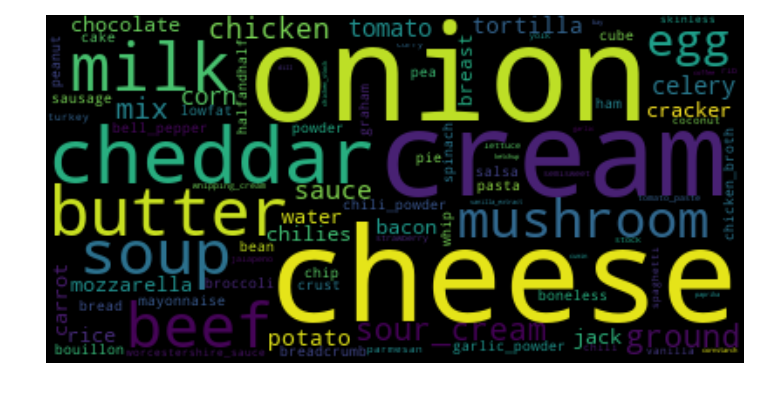

In [639]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
figure(figsize=(9, 8), dpi=100)
#fig = plt.figure()
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d4)
#plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [804]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [805]:
display_topics(lsa, vectorizer.get_feature_names(), 15)


Topic  0
salt, pepper, onion, oil, sugar, ground, egg, butter, powder, cream, water, juice, tomato, sauce, milk

Topic  1
sugar, egg, butter, vanilla, milk, cream, chocolate, soda, flour, powder, cinnamon, extract, brown, chip, cocoa

Topic  2
ground, sugar, cinnamon, powder, ginger, cumin, juice, coriander, beef, chili, orange, allspice, soda, apple, brown

Topic  3
ground, cream, cheese, onion, beef, cheddar, butter, soup, milk, mushroom, powder, egg, cumin, chicken, tomato

Topic  4
juice, cream, sauce, lemon, sugar, orange, cheese, water, oil, soy, onion, lime, clove, ginger, chicken

Topic  5
powder, onion, sauce, water, chili, tomato, oil, beef, sugar, soy, rice, worcestershire, bean, seed, flour

Topic  6
powder, juice, lemon, pepper, orange, onion, chili, lime, cumin, butter, salt, mayonnaise, cayenne, curry, celery

Topic  7
oil, powder, cream, salt, cheese, juice, egg, lemon, flour, milk, cumin, virgin, orange, ground, wheat

Topic  8
pepper, sauce, powder, cream, oil, sugar

In [411]:
# NMF
nmf_model = NMF(4)
doc_topic_nmf = nmf_model.fit_transform(doc_word)

In [412]:
display_topics(nmf_model, vectorizer.get_feature_names(), 15)


Topic  0
pepper, salt, olive_oil, garlic_clove, parsley, lemon_juice, wine, leaf, tomato, flake, virgin, basil, vinegar, butter, mustard

Topic  1
sugar, egg, butter, salt, milk, baking_powder, vanilla, water, baking_soda, flour, cinnamon, cream, brown, vanilla_extract, chocolate

Topic  2
ground, cinnamon, cumin, ginger, beef, coriander, chili_powder, allspice, pork, seed, apple, sauce, garlic_clove, vegetable_oil, cilantro

Topic  3
onion, cheese, water, tomato, beef, cream, mushroom, celery, sauce, cheddar, carrot, rice, soup, chicken, potato


## Content-based Recommender

### With LSA

In [744]:
#create df with features for each recipe based on topic modeling
recipe_features = pd.DataFrame(doc_topic_lsa,index = df.id.tolist(), columns = [ 'Misc', 'Baking', 'Spices','Soup', 'chicken', 'beef'])

In [789]:
df

,id,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,ingredients_text,Doc,Topic,Probability,tags-cleaned,type,tags_cleaned
0,137739,arriba baked winter squash mexican style,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,winter squash mexican seasoning mixed spice ho...,0,5,0.747597,minutesorless timetomake course mainingredient...,"[northamerican, mexican, vegetarian]",minutesorless timetomake course mainingredient...
1,31490,a bit different breakfast pizza,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,prepared pizza crust sausage patty eggs milk s...,1,0,0.993796,minutesorless timetomake course mainingredient...,"[northamerican, breakfast, american]",minutesorless timetomake course mainingredient...
2,112140,all in the kitchen chili,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,ground beef yellow onions diced tomatoes tomat...,2,3,0.441226,timetomake course preparation maindish chili c...,[],timetomake course preparation maindish chili c...
3,59389,alouette potatoes,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,spreadable cheese with garlic and herbs new po...,3,5,0.817536,minutesorless timetomake course mainingredient...,[],minutesorless timetomake course mainingredient...
4,44061,amish tomato ketchup for canning,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,tomato juice apple cider vinegar sugar salt pe...,4,3,0.712420,weeknight timetomake course mainingredient cui...,"[northamerican, american, vegetarian]",weeknight timetomake course mainingredient cui...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231632,486161,zydeco soup,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22,celery onion green sweet pepper garlic cloves ...,231632,5,0.658548,ham minutesorless timetomake course mainingred...,"[northamerican, american]",ham minutesorless timetomake course mainingred...
231633,493372,zydeco spice mix,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13,paprika salt garlic powder onion powder dried ...,231633,5,0.742429,minutesorless timetomake course preparation fo...,"[vegan, vegetarian]",minutesorless timetomake course preparation fo...
231634,308080,zydeco ya ya deviled eggs,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', '

In [806]:
dist = pairwise_distances(doc_topic_lsa[3].reshape(1,-1), doc_topic_lsa)
dist.argsort() 

array([[     3,  56582,  41672, ..., 144995, 115807,  68916]], dtype=int64)

In [811]:
dist.argsort()[0][3]

217108

In [814]:
df.iloc[3]['ingredients']

"['spreadable cheese with garlic and herbs', 'new potatoes', 'shallots', 'parsley', 'tarragon', 'olive oil', 'red wine vinegar', 'salt', 'pepper', 'red bell pepper', 'yellow bell pepper']"

In [440]:
df.iloc[198908]

id                                                             205983
name                                     stacked crock pot enchiladas
minutes                                                           435
contributor_id                                                 166642
submitted                                                  2007-01-17
tags                ['course', 'main-ingredient', 'preparation', '...
nutrition                [807.7, 49.0, 20.0, 60.0, 110.0, 79.0, 25.0]
n_steps                                                             8
steps               ['in a skillet , cook beef , onions and green ...
description         even though, i love enchiladas you make in the...
ingredients         ['lean ground beef', 'onion', 'green bell pepp...
n_ingredients                                                      13
ingredients_text    lean ground beef onion green bell pepper kidne...
Doc                                                            198908
Topic               

### With NMF

In [413]:
#create df with features for each recipe based on topic modeling
recipe_features = pd.DataFrame(doc_topic_nmf,index = df.id.tolist(), columns = [ 'Misc', 'Baking', 'Spices','Soup'])

In [414]:
dist = pairwise_distances(doc_topic[1].reshape(1,-1), doc_topic)
dist.argsort() 

array([[     1,  80548,   9912, ..., 115807, 144995,  68916]], dtype=int64)

In [415]:
df.iloc[1]

id                                                              31490
name                                 a bit different  breakfast pizza
minutes                                                            30
contributor_id                                                  26278
submitted                                                  2002-06-17
tags                ['30-minutes-or-less', 'time-to-make', 'course...
nutrition                   [173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]
n_steps                                                             9
steps               ['preheat oven to 425 degrees f', 'press dough...
description         this recipe calls for the crust to be prebaked...
ingredients         ['prepared pizza crust', 'sausage patty', 'egg...
n_ingredients                                                       6
ingredients_text    prepared pizza crust sausage patty eggs milk s...
Name: 1, dtype: object

In [416]:
df.iloc[80548]

id                                                             473913
name                           enchantress s ham   pepper jack quiche
minutes                                                            55
contributor_id                                                  85746
submitted                                                  2012-02-09
tags                ['60-minutes-or-less', 'time-to-make', 'course...
nutrition                   [215.6, 22.0, 1.0, 28.0, 31.0, 45.0, 1.0]
n_steps                                                             4
steps               ['beat the eggs , milk , salt and pepper well'...
description                a crust-less, low carb quiche with a kick!
ingredients         ['egg whites', 'evaporated milk', 'ham', 'blac...
n_ingredients                                                       6
ingredients_text    egg whites evaporated milk ham black pepper sa...
Name: 80548, dtype: object

### LDA

In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(corpus)
# Filter out tokens that appear in only 1 documents and appear in more than 90% of the documents
id2word.filter_extremes(no_below=2, no_above=0.9)
# Create Corpus
texts = corpus
# Term Document Frequency
corpus_lda = [id2word.doc2bow(text) for text in texts]

lda_model = gensim.models.LdaMulticore(corpus=corpus_lda,
 id2word=id2word,
 num_topics=10, 
 random_state=100,
 chunksize=100,
 passes=10,
 alpha=0.01,
 eta=0.9)


In [ ]:
# Print the Keyword in the 6 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus_lda]

In [ ]:
def Sort_Tuple(tup):  
    return(sorted(tup, key = lambda x: x[1], reverse = True))   
doc_num, topic_num, prob = [], [], []
print(lda_model.get_document_topics(corpus_lda))
for n in range(len(df)):
    get_document_topics = lda_model.get_document_topics(corpus_lda[n])
    doc_num.append(n)
    sorted_doc_topics = Sort_Tuple(get_document_topics)
    topic_num.append(sorted_doc_topics[0][0])
    prob.append(sorted_doc_topics[0][1])
df['Doc'] = doc_num
df['Topic'] = topic_num
df['Probability'] = prob
df.to_csv("doc_topic_matrix.csv", index=False)

In [820]:
df

,id,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,ingredients_text,Doc,Topic,Probability,tags-cleaned,type,tags_cleaned
0,137739,arriba baked winter squash mexican style,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,winter squash mexican seasoning mixed spice ho...,0,1,0.666465,minutesorless timetomake course mainingredient...,"[northamerican, mexican, vegetarian]",minutesorless timetomake course mainingredient...
1,31490,a bit different breakfast pizza,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,prepared pizza crust sausage patty eggs milk s...,1,3,0.993796,minutesorless timetomake course mainingredient...,"[northamerican, breakfast, american]",minutesorless timetomake course mainingredient...
2,112140,all in the kitchen chili,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,ground beef yellow onions diced tomatoes tomat...,2,0,0.573701,timetomake course preparation maindish chili c...,[],timetomake course preparation maindish chili c...
3,59389,alouette potatoes,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11,spreadable cheese with garlic and herbs new po...,3,1,0.895774,minutesorless timetomake course mainingredient...,[],minutesorless timetomake course mainingredient...
4,44061,amish tomato ketchup for canning,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,tomato juice apple cider vinegar sugar salt pe...,4,5,0.710114,weeknight timetomake course mainingredient cui...,"[northamerican, american, vegetarian]",weeknight timetomake course mainingredient cui...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231632,486161,zydeco soup,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22,celery onion green sweet pepper garlic cloves ...,231632,1,0.470750,ham minutesorless timetomake course mainingred...,"[northamerican, american]",ham minutesorless timetomake course mainingred...
231633,493372,zydeco spice mix,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13,paprika salt garlic powder onion powder dried ...,231633,1,0.561186,minutesorless timetomake course preparation fo...,"[vegan, vegetarian]",minutesorless timetomake course preparation fo...
231634,308080,zydeco ya ya deviled eggs,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', '

In [ ]:
def recommend_by_recipe_content(name, df):
    recommended = []
    top10_list = []

    name = name.lower()
    df['name'] = df['name'].str.lower()
    topic_num = df[df['name']==name].Topic.values
    doc_num = df[df['name']==name].Doc.values 

    output_df = df[df['Topic']==topic_num[0]].sort_values('Probability', ascending=False).reset_index(drop=True)
    index = output_df[output_df['Doc']==doc_num[0]].index[0]

    top10_list += list(output_df.iloc[index-5:index].index)
    top10_list += list(output_df.iloc[index+1:index+6].index)

    output_df['name'] = output_df['name'].str.title()

    for each in top10_list:
        recommended.append(output_df.iloc[each]['name'])
 
    return recommended

In [ ]:
recommend_by_recipe_content('alouette  potatoes', df)

In [449]:
df.name

0           arriba   baked winter squash mexican style
1                     a bit different  breakfast pizza
2                            all in the kitchen  chili
3                                   alouette  potatoes
4                   amish  tomato ketchup  for canning
                              ...                     
231632                                     zydeco soup
231633                                zydeco spice mix
231634                       zydeco ya ya deviled eggs
231635          cookies by design   cookies on a stick
231636    cookies by design   sugar shortbread cookies
Name: name, Length: 231637, dtype: object

# Corex

In [576]:
from corextopic import corextopic as ct

In [669]:
words = list(np.asarray(vectorizer.get_feature_names()))
topic_model = ct.Corex(n_hidden= 4, 
                       words=words, 
                       seed=1
                       )

topic_model.fit(doc_word,          
                words= words,     
                docs= new_corpus)  

In [670]:
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print(f'{n}: {", ".join(topic_words)}')

0: onion, pepper, olive_oil, vanilla, tomato, garlic_clove, parsley, mushroom, chocolate, celery
1: sugar, egg, baking_powder, baking_soda, cinnamon, vanilla_extract, brown, flour, confectioner, cocoa
2: cumin, butter, beef, leaf, cilantro, ground, vinegar, milk, soy_sauce, chili_powder
3: cheese, cream, cheddar, soup, mozzarella, tortilla, sour_cream, jack, ginger, salsa


In [656]:
topic_model = ct.Corex(n_hidden= 4, 
                       words=words, 
                       seed=1
                       )

topic_model.fit(doc_word,          
                words= words,     
                docs= new_corpus, 
                anchors=[
                         [ 'baking', 'sugar', 'flour', 'chocolate'],
                         ['juice', 'syrup'],
                         ['chicken', 'boneless', 'breast' ],
                    ['beef',  'pork']],
                anchor_strength=5   
                );

In [666]:
l = []
for i in topic_model.get_topics():
    d = {}
    for ingredient, score, f in i:
        d[ingredient] = score
    l.append(d)

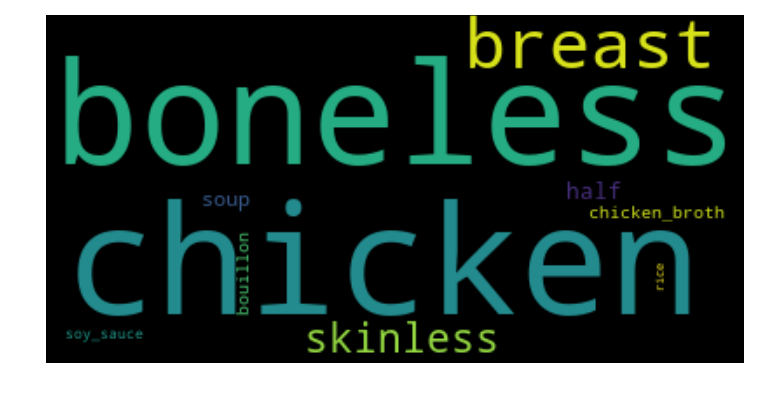

In [672]:
figure(figsize=(9, 8), dpi=100)
#fig = plt.figure()
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=l[2])
#plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [658]:
topics = topic_model.get_topics()

for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print(f'{n}: {", ".join(topic_words)}')

0: sugar, chocolate, flour, brown, baking_soda, baking_powder, egg, onion, pepper, vanilla
1: juice, syrup, lime, maple, pineapple, cilantro, corn, ice, cranberry, rum
2: chicken, boneless, breast, skinless, half, soup, bouillon, chicken_broth, soy_sauce, rice
3: beef, pork, ground, chop, sauce, worcestershire_sauce, tomato_paste, chili_powder, ketchup, steak


In [664]:
#try cuisine types
topic_model2 = ct.Corex(n_hidden= 4, 
                       words=words, 
                       seed=1
                       )

topic_model2.fit(doc_word,          
                words= words,     
                docs= new_corpus, 
                anchors=[
                         [ 'italian', 'olive_oil', 'basil', 'pasta'],
                         ['mexican', 'chili', 'tortilla', 'beans', 'salsa', 'cilantro','avocado'],
                    ['asian',  'soy_sauce', 'rice', 'pork', 'ginger'],
                    ['american', 'hamburger', 'macaroni', 'ribs', 'ketchup', 'cheddar']],
                anchor_strength=5   
                );

In [665]:
topics = topic_model2.get_topics()

for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print(f'{n}: {", ".join(topic_words)}')

0: olive_oil, basil, pasta, virgin, pepper, sugar, garlic_clove, tomato, vanilla, parsley
1: cilantro, chili, tortilla, salsa, cumin, lime, onion, jalapeno, juice, sauce
2: rice, ginger, soy_sauce, pork, sesame_oil, chop, ground, sodium, vinegar, boneless
3: cheddar, ketchup, cheese, sour_cream, soup, beef, bacon, worcestershire_sauce, orange, mustard


In [673]:
l2 = []
for i in topic_model2.get_topics():
    d = {}
    for ingredient, score, f in i:
        d[ingredient] = score
    l2.append(d)

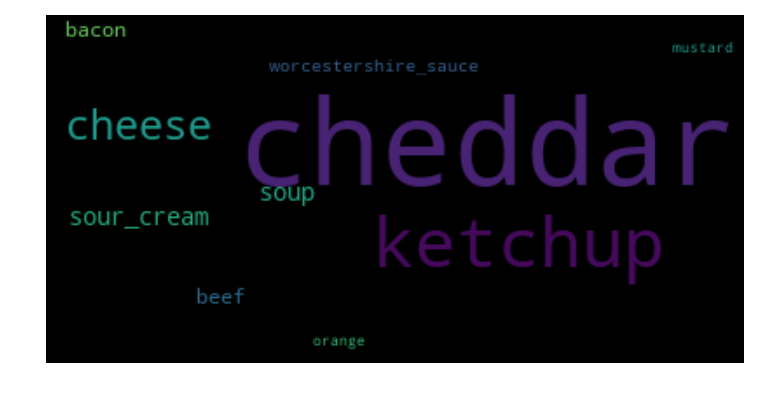

In [677]:
figure(figsize=(9, 8), dpi=100)
#fig = plt.figure()
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=l2[3])
#plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Recipe Tags

In [533]:
def clean_string(row):
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    text = row['tags']
    for ele in text:
        if ele in punc:
            pattern = r'[0-9]'
            text = text.lower()
            text = text.replace(ele, "")
            text = re.sub(pattern, '', text)
    return text
df['tags_cleaned'] = df.apply(clean_string, axis=1)

In [536]:
d = {}
for recipe in df.tags_cleaned.tolist():
    for tag in recipe.split():
        if tag in d:
            d[tag] += 1
        else:
            d[tag] = 1
d

{'minutesorless': 169001,
 'timetomake': 225326,
 'course': 218148,
 'mainingredient': 170446,
 'cuisine': 91165,
 'preparation': 230546,
 'occasion': 114145,
 'northamerican': 48479,
 'sidedishes': 26902,
 'vegetables': 53814,
 'mexican': 6694,
 'easy': 126062,
 'fall': 7754,
 'holidayevent': 34920,
 'vegetarian': 35651,
 'winter': 7654,
 'dietary': 165091,
 'christmas': 8145,
 'seasonal': 21933,
 'squash': 3696,
 'breakfast': 13655,
 'maindish': 71786,
 'pork': 12692,
 'american': 31179,
 'oven': 31180,
 'kidfriendly': 27074,
 'pizza': 1505,
 'northeasternunitedstates': 2566,
 'meat': 56042,
 'equipment': 70436,
 'chili': 1693,
 'crockpotslowcooker': 6608,
 'hoursorless': 49497,
 'eggsdairy': 30142,
 'potatoes': 10293,
 'dinnerparty': 37561,
 'easter': 2368,
 'cheese': 15147,
 'stovetop': 22095,
 'newyears': 2487,
 'thanksgiving': 4357,
 'independenceday': 2359,
 'stpatricksday': 828,
 'valentinesday': 2680,
 'inexpensive': 32619,
 'brunch': 18927,
 'superbowl': 2089,
 'presentation'

In [539]:
#!pip install WordCloud

You should consider upgrading via the 'c:\users\salma.katri\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


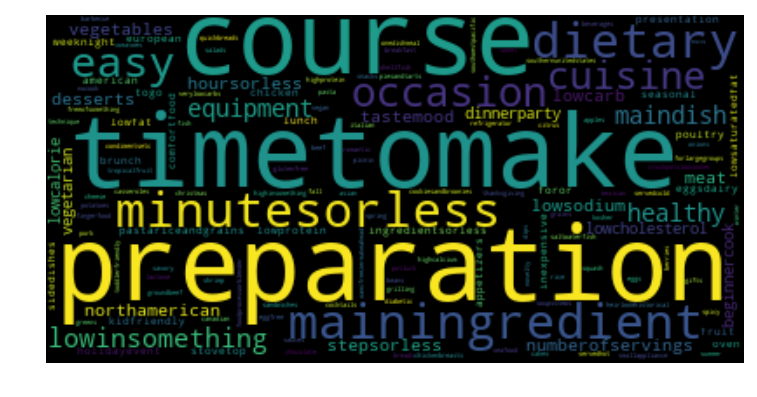

In [587]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
figure(figsize=(9, 8), dpi=100)
#fig = plt.figure()
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=d)
#plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [553]:
tags = list(d.keys())
count = list(d.values())
tags_count = pd.DataFrame(count,tags).reset_index()
tags_count.columns = ['Tags', 'Count']

In [572]:
len(tags)

555

In [558]:
tags_count = tags_count.sort_values(by='Count', ascending=False)

In [562]:
tags_count[:50]

,Tags,Count
5,preparation,230546
1,timetomake,225326
2,course,218148
3,mainingredient,170446
0,minutesorless,169001
16,dietary,165091
11,easy,126062
6,occasion,114145
4,cuisine,91165
63,lowinsomething,85776


<Figure size 900x800 with 0 Axes>

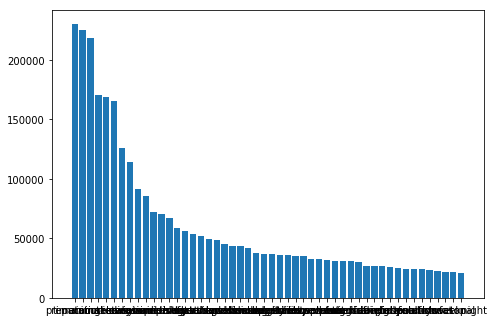

In [564]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(9, 8), dpi=100)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(tags_count[:50].Tags,tags_count[:50].Count)
plt.show()

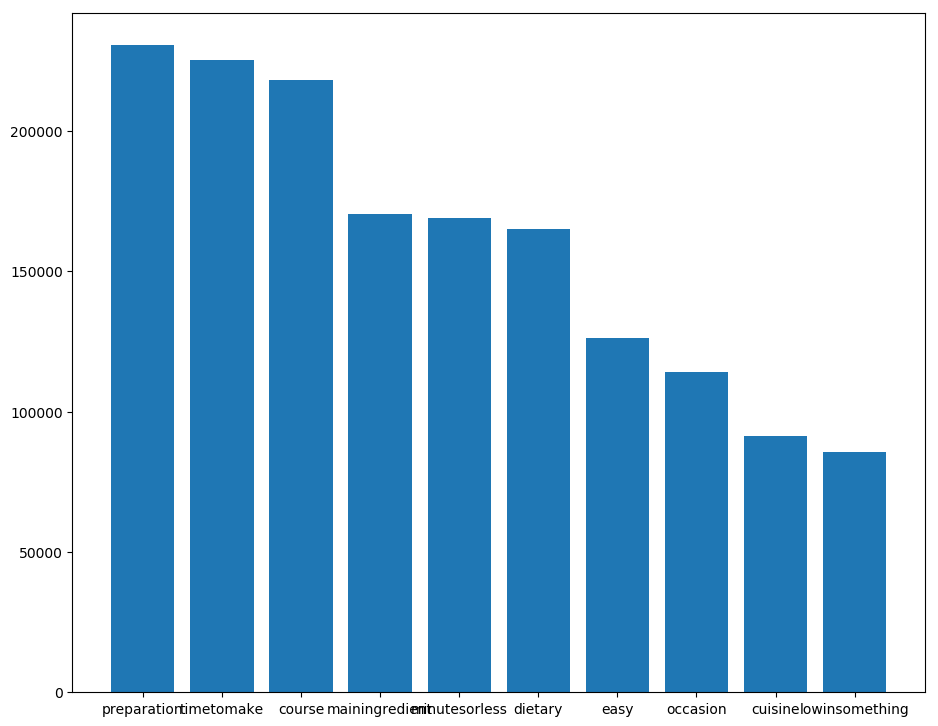

In [575]:
figure(figsize=(11, 9), dpi=100)
plt.bar(tags_count[:10].Tags,tags_count[:10].Count)
plt.show()